<a href="https://colab.research.google.com/github/Juntolli/comp215/blob/main/labs/lab06_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COMP 215 - LAB 6
----------------
#### Name(s): Bruno Juntolli
#### Date: Feb 26, 2025

By the end of this lab you should be able to:
  * create a Watts-Strogatz graph both from scratch and from the Networkx module
  * measure the average clustering coefficient and path length of a network
  * visualize summative data of a graph


During this lab, you will be introduced to the following:
  * numpy arrays
  * local file i/o in Google Colab

(this lab is based on workbooks provided in Allen Downey's 'Think Complexity')

## Social Networking

This lab uses graphs to explore social networks using Facebook data.  In this lab you will create a simulated model of the network using a Watts-Strogatz graph and compare some properties of the simulated network and the real Facebook network.

In [ ]:
# put your imports here

In [1]:
import numpy as np
import networkx as nx
import random
from collections import deque
import matplotlib.pyplot as plt
import unittest

## Get the Facebook Data

Stanford Network Analysis Platform (SNAP) is a general purpose network analysis and graph mining library.  In previous labs, we have used APIs to access data.  For this lab, we will copy the data to a local file.  Download the ```facebook_combined.txt.gz``` file from [SNAP](https://snap.stanford.edu/data/egonets-Facebook.html), unzip it, and copy ```facebook_combined.txt``` to the ```Files``` folder in Colab.  

Look at the content of the file and read the SNAP webpage to understand what the data represents before moving on to the rest of the lab.

## Exercise 1: Make Facebook Graph

Write a function that reads the file, one edge per line, specified by the two integer node IDs given in each line of the file and returns a ```networkx``` graph representing the data.  You can do this with Python's built-in file handling, or you could use ```numpy```'s ```loadtxt``` function.  Write a unit test to check that the network has 4039 nodes and 88234 edges (as given in the Dataset Statistics on the SNAP site) and draw the Facebook network (this takes about a minute).


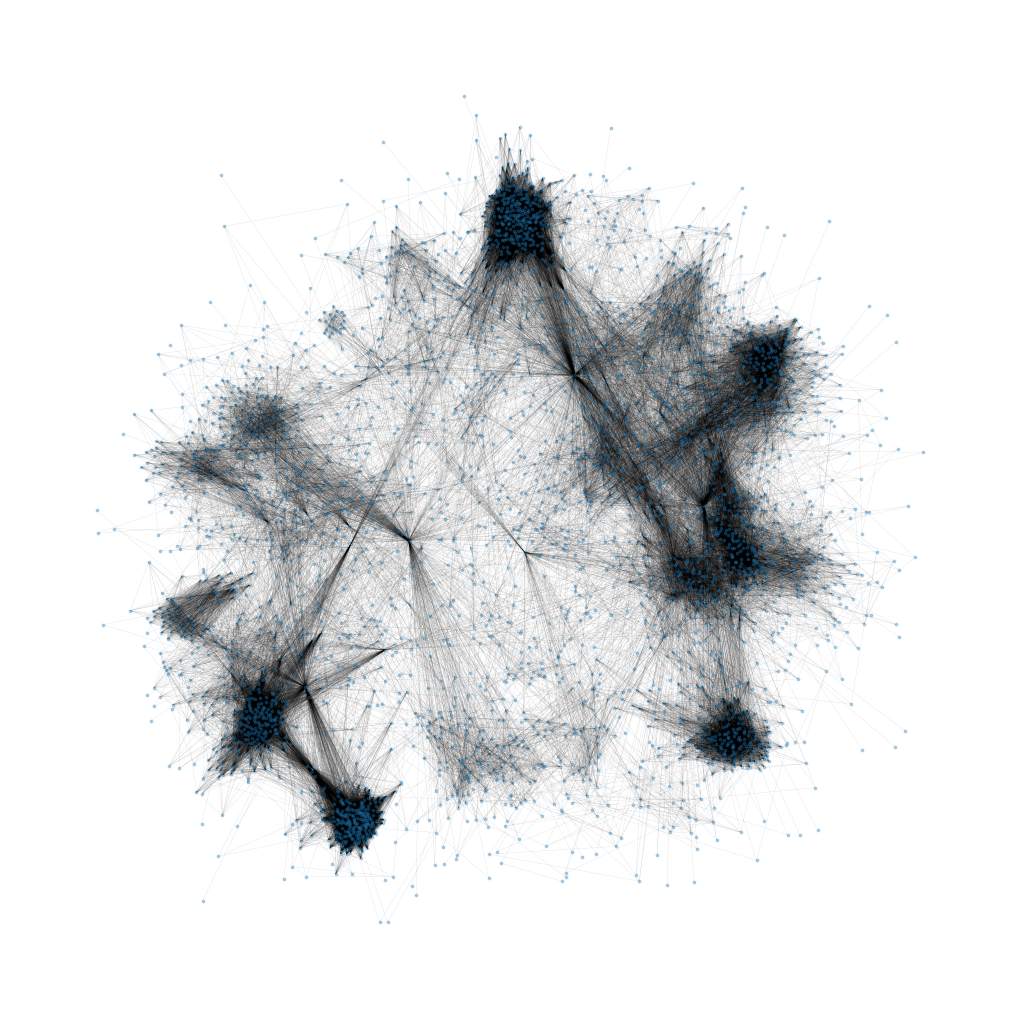

.
----------------------------------------------------------------------
Ran 1 test in 0.296s

OK


In [3]:
# Ex 1 code here

# read file
def make_facebook_graph(facebook_file:str):
  facebook_graph = nx.Graph()

  with open(facebook_file, "r") as file:
    for line in file:
      node_1, node_2 = map(int, line.split())
      facebook_graph.add_edge(node_1, node_2)

  return facebook_graph


def draw_graph(facebook_file:str):

  graph = make_facebook_graph(facebook_file)
  pos = nx.spring_layout(graph, k=0.15)
  plt.figure(figsize=(10, 10))
  nx.draw(graph, pos, node_size=3, width=0.1, alpha=0.3)
  plt.show()


class TestFacebookGraph(unittest.TestCase):
  def test_graph(self):
    graph = make_facebook_graph("facebook_combined.txt")
    self.assertEqual(graph.number_of_nodes(), 4039)
    self.assertEqual(graph.number_of_edges(), 88234)


draw_graph("facebook_combined.txt")

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)


## Exercise 2: Clustering Coefficients

With larger graphs, it can take a long time to compute clustering coefficients and path lengths. We can estimate them by sampling without much loss of accuracy if the sample size is large enough.  Write a function that calculates the average clustering coeffient for a random subset of a N pairs of nodes in a network.  You may use the ```node_clustering``` and ```all_pairs``` functions from Chapter 5 of the textbook.  You may also use the ```numpy``` module to calculate the mean; note that there is a ```nanmean``` function.

Check that your clustering coeffients function gives a similar answer to the ```networkx``` ```average_clustering``` function.


In [24]:
# Ex 2 code here

def sample_random_nodes(graph, N):
  nodes = list(graph.nodes())
  return random.sample(nodes, N)

def compute_sampled_clustering(graph, N):
  sampled_nodes = sample_random_nodes(graph, N)
  clustering_values = [nx.clustering(graph, node) for node in sampled_nodes]
  return clustering_values

def average_sampled_clustering(graph, N):
  clustering_values = compute_sampled_clustering(graph, N)
  return np.nanmean(clustering_values)


facebook_graph = make_facebook_graph("facebook_combined.txt")
N = 500

sampled_avg_clustering = average_sampled_clustering(facebook_graph, N)
networx_avg_clustering = nx.average_clustering(facebook_graph)

print(f"Estimated Average Clustering Coefficient: {sampled_avg_clustering},\nAnd by using networx 'average_clustering': {networx_avg_clustering}. \nDifference: {abs(sampled_avg_clustering - networx_avg_clustering) / networx_avg_clustering * 100:.3f} %")

Estimated Average Clustering Coefficient: 0.6041444008707478,
And by using networx 'average_clustering': 0.6055467186200876. 
Difference: 0.232 %


## Exercise 3: Average Shortest Path Length

Write a function that calculates the average shortest path length for all pairs of nodes in a network.  You may use the ```shortest_path_dijkstra``` function from Chapter 5 of the textbook.  Using that function, it took my algorithm about 2 minutes to find the average shortest path over all pairs of nodes.


Check that your average shortest path length function gives a similar answer to the ```networkx``` ```average_shortest_path_length``` function.


In [33]:
# Ex 3 code here

def shortest_path_dijkstra(G, source):
  # Function taken from chapter 5 of the textbook 'Think Complexity' by Allen Downey
  # Returns a dictionary mapping each reachable node (key) to its shortest path distance (value) from the source

  dist = {source: 0}
  queue = deque([source])
  while queue:
      node = queue.popleft()
      new_dist = dist[node] + 1
      neighbors = set(G[node]).difference(dist)
      for n in neighbors:
          dist[n] = new_dist

      queue.extend(neighbors)
  return dist


def calculate_average_shortest_path(graph):
    total_distance = 0
    count_pairs = 0
    nodes = list(graph.nodes())
    n = len(nodes)

    for i in range(n):
        distances = shortest_path_dijkstra(graph, nodes[i])
        for j in range(i + 1, n):
            if nodes[j] in distances:
                total_distance += distances[nodes[j]]
                count_pairs += 1

    print("Total pairs counted:", count_pairs)

    if count_pairs == 0:
        return float('inf')
    return total_distance / count_pairs

average_path_length = calculate_average_shortest_path(facebook_graph)
networx_avg_path_length = nx.average_shortest_path_length(facebook_graph)
print(f"Average shortest path length: {average_path_length}\nAnd by using networx 'Average Shortest Path Length function: {networx_avg_path_length}")

Total pairs counted: 8154741
Average shortest path length: 3.6925068496963913
And by using networx 'Average Shortest Path Length function: 3.6925068496963913


Here is a function from the textbook that takes a sample of path lengths to estimate the average shortest path length.  You may use this in the rest of the lab so that you don't need to wait for the whole full averaging algorithms above to run.

In [27]:

def sample_path_lengths(G, nodes=None, trials=100):
    """Choose random pairs of nodes and compute the path length between them.
    G: Graph
    N: number of pairs to choose
    returns: list of path lengths
    """
    if nodes is None:
        nodes = list(G)
    else:
        nodes = list(nodes)

    pairs = np.random.choice(nodes, (trials, 2))
    lengths = [nx.shortest_path_length(G, *pair)
               for pair in pairs]
    return lengths

def estimate_path_length(G, nodes=None, trials=1000):
    return np.mean(sample_path_lengths(G, nodes, trials))

In the exercises above, you should have found that the Facebook network has an average clustering coefficient around 0.6 and an average shortest path length of around 3.7. Note that this corresponds to a 'degree of separation' of less than 6.   

## Exercise 4: WS Graph

Construct a WS graph with the same number of nodes and average degree as the Facebook network using the ```make_ws_graph``` function from Chapter 5.  Find the value of p (probability of rewire) that reproduces a clustering coefficient and average shortest path length of the Facebook network.  (Note that there is a ```nx.watts_strogatz_graph``` that you may use after you have demonstrated that you can create a WS graph using the functions from Chapter 5.).

What could this value of p tell you about the actual social network that this Facebook data represents?  (Think about what p means in the model and what that would represent in the data.)

In [ ]:
# Ex 4 code here

